In [20]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import datetime
import scipy
import pickle

In [19]:
import pickle
with open("/so/home/jsugiyama/work/GNSS_PWV/gnsspwv_20230101_20240515.pickle", mode="rb") as f:
    database = pickle.load(f)

In [4]:
database.keys()

dict_keys(['timestamps', 'gnss_zwd', 'apex_pwv'])

GNSS paper: https://doi.org/10.1093/mnras/stae270 \
software to convert gnss data to zwd: https://github.com/17-sugiyama/GNSS_processing/tree/main \
The data transfer was set up by Haruki Nishino, and instruments were installed by Nolberto Oyarce and José Cortes. 

``gnss_zwd`` is output of the csrs-ppp (software to analyze gnss data). \
ZWD (zenith wet delay) is converted to PWV by following alithmetics.

In [5]:
gnsspwv = database["gnss_zwd"]*0.15
a = 1.046
b = 1.08
gnsspwv = (gnsspwv - b)/a

``apex_pwv`` is PWV measured by Atacama Pathfinder experiment's radiometer. \
The altitude dependence of PWV around Atacama is estimated by Otárola et al. ( 2010 )\
The altitude difference of SO (5192 m) and APEX (5064 m) is corrected by the following equation.

In [6]:
def PWV_APEXtoSA(PWV_APEX):
    return PWV_APEX*np.exp((-5192+5064)/2300)
apexpwv = PWV_APEXtoSA(database["apex_pwv"])

GNSS PWV is noisy compared to the radiometer PWV. Avaraging PWV for 1h reduces the noise.

Text(0, 0.5, 'PWV (mm)')

/so/shared-software/miniconda3/envs/so-base-py310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/so/shared-software/miniconda3/envs/so-base-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


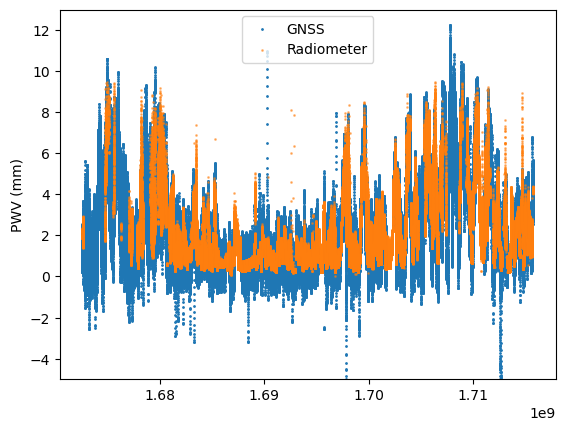

In [11]:
plt.figure()
plt.scatter(database["timestamps"], gnsspwv, s=1, label="GNSS")
plt.scatter(database["timestamps"], apexpwv, s=1, label="Radiometer", alpha=0.5)

plt.ylim(-5, 13)
plt.legend()
plt.ylabel("PWV (mm)")

In [12]:
apexpwv_1h=[[],[]]
gnsspwv_1h=[[],[]]
time_1h = []
for i in range(len(database["timestamps"])//60):
    apexpwv_1h[0].append(np.nanmedian(apexpwv[i*60:(i+1)*60]))
    gnsspwv_1h[0].append(np.nanmedian(gnsspwv[i*60:(i+1)*60]))
    
    apexpwv_1h[1].append(np.nanstd(apexpwv[i*60:(i+1)*60])/np.sqrt(60))
    gnsspwv_1h[1].append(np.nanstd(gnsspwv[i*60:(i+1)*60])/np.sqrt(60))
    
    time_1h.append(database["timestamps"][i*60])

/tmp/ipykernel_163884/1553140325.py:5: RuntimeWarning: All-NaN slice encountered
  apexpwv_1h[0].append(np.nanmedian(apexpwv[i*60:(i+1)*60]))
/so/home/jsugiyama/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_163884/1553140325.py:6: RuntimeWarning: All-NaN slice encountered
  gnsspwv_1h[0].append(np.nanmedian(gnsspwv[i*60:(i+1)*60]))


Text(0, 0.5, 'PWV (mm)')

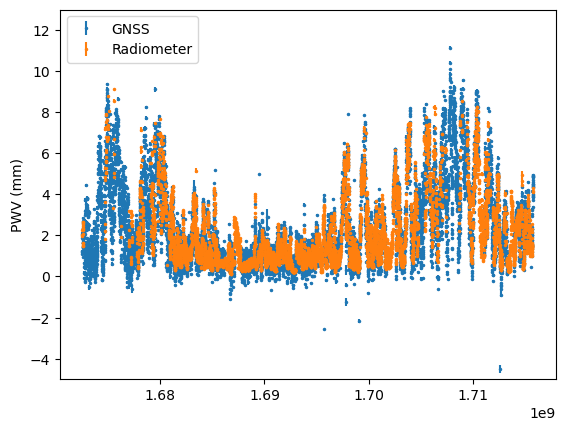

In [18]:
plt.figure()
plt.errorbar(time_1h, gnsspwv_1h[0], yerr=gnsspwv_1h[1], fmt=".", ms=3, label="GNSS")
plt.errorbar(time_1h, apexpwv_1h[0], yerr=apexpwv_1h[1], fmt=".", ms=3, label="Radiometer")

plt.ylim(-5, 13)
plt.legend()
plt.ylabel("PWV (mm)")

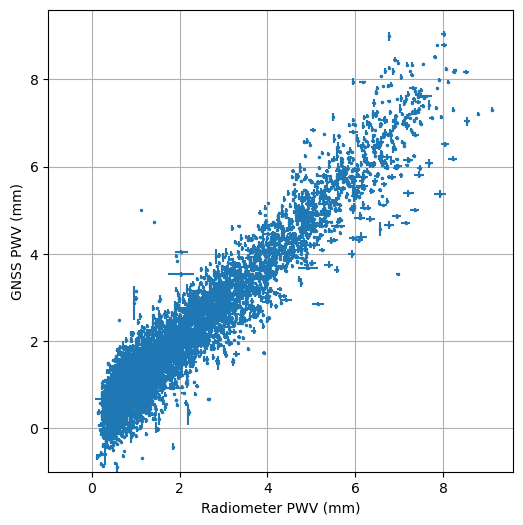

In [26]:
plt.figure(figsize=(6,6))
plt.errorbar(apexpwv_1h[0], gnsspwv_1h[0], xerr=apexpwv_1h[1], yerr=gnsspwv_1h[1], fmt=".", ms=3)
plt.xlabel("Radiometer PWV (mm)")
plt.ylabel("GNSS PWV (mm)")
plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])
plt.ylim(-1, 9.6)
plt.xlim(-1, 9.6)
plt.grid()